In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


In [2]:
import tensorflow as tf
print(tf.__version__)

#tf.enable_eager_execution()


2.4.1


In [3]:
import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteFBQFCR/imdb_reviews-train.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteFBQFCR/imdb_reviews-test.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteFBQFCR/imdb_reviews-unsupervised.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [5]:
train_data,test_data=imdb['train'],imdb['test']

#train_data.head()

In [6]:
train_data

<PrefetchDataset shapes: ((), ()), types: (tf.string, tf.int64)>

In [19]:
def data_to_numpy(data):
    sentences=[]
    labels=[]
    
    for sentence,label in data:
        sentences.append(str(sentence.numpy()))
        labels.append(label.numpy())
    
    labels_np=np.array(labels)
    sentences_np=np.array(sentences)
    
    return sentences_np,labels_np

In [20]:
training_sentences , training_labels=data_to_numpy(train_data)
test_sentences , test_labels=data_to_numpy(test_data)

X_train=training_sentences
y_train=training_labels
X_test=test_sentences
y_test=test_labels

In [21]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(25000,)
(25000,)
(25000,)
(25000,)


In [24]:
X_train.shape


(25000,)

Model Prepartion

In [25]:

vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(X_train)
training_padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

X_test = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(X_test,maxlen=max_length)

In [29]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 1920)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               245888    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 406,017
Trainable params: 406,017
Non-trainable params: 0
_________________________________________________________________


In [30]:
num_epochs=30

history=model.fit(training_padded,y_train,epochs=num_epochs,validation_data=(testing_padded,y_test))

Epoch 1/30
782/782 [==============================] - 5s 5ms/step - loss: 0.5473 - accuracy: 0.6977 - val_loss: 0.3520 - val_accuracy: 0.8439
Epoch 2/30
782/782 [==============================] - 4s 5ms/step - loss: 0.1969 - accuracy: 0.9282 - val_loss: 0.4469 - val_accuracy: 0.8157
Epoch 3/30
782/782 [==============================] - 4s 5ms/step - loss: 0.0414 - accuracy: 0.9886 - val_loss: 0.7265 - val_accuracy: 0.8018
Epoch 4/30
782/782 [==============================] - 4s 5ms/step - loss: 0.0074 - accuracy: 0.9991 - val_loss: 0.8481 - val_accuracy: 0.8133
Epoch 5/30
782/782 [==============================] - 4s 5ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.9205 - val_accuracy: 0.8158
Epoch 6/30
782/782 [==============================] - 4s 5ms/step - loss: 2.1041e-04 - accuracy: 1.0000 - val_loss: 0.9601 - val_accuracy: 0.8166
Epoch 7/30
782/782 [==============================] - 4s 5ms/step - loss: 1.0671e-04 - accuracy: 1.0000 - val_loss: 0.9968 - val_accuracy: 0.817

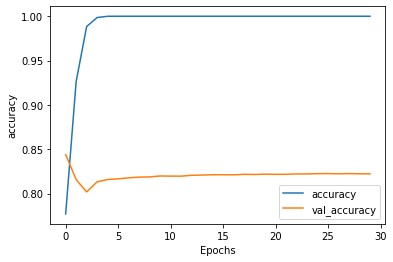

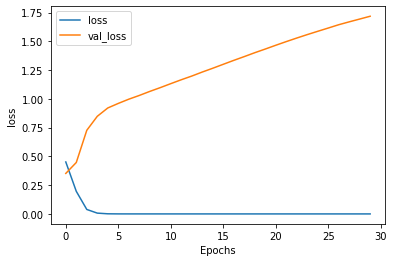

In [31]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
      plt.plot(history.history[string])
      plt.plot(history.history['val_'+string])
      plt.xlabel("Epochs")
      plt.ylabel(string)
      plt.legend([string, 'val_'+string])
      plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")